Analysis of the evalutation results

In [47]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

results_dir = "../data/local_eval/"
result_files = glob.glob(os.path.join(results_dir, "**/*_results.json"), recursive=True)

all_results = []
for file in result_files:
    with open(file, "r") as f:
        data = json.load(f)
    model_dir = os.path.basename(os.path.dirname(file))
    approach = os.path.basename(file).replace("_results.json", "")
    row = {
        "model": model_dir,
        "approach": approach,
        "accuracy": data.get("accuracy"),
        "chatgpt": data.get("chatgpt"),
        "match": data.get("match"),
    }

    for k, v in data.get("language", {}).items():
        row[k] = v

    all_results.append(row)


df = pd.DataFrame(all_results)

In [ ]:
# Table Comparison
language_keys = [
    "val/Bleu_1",
    "val/Bleu_2",
    "val/Bleu_3",
    "val/Bleu_4",
    "val/ROUGE_L",
    "val/CIDEr",
]
score_keys = ["accuracy", "chatgpt", "match"] + language_keys

display_cols = ["model", "approach"] + score_keys
display(df[display_cols])

,model,approach,accuracy,chatgpt,match,val/Bleu_1,val/Bleu_2,val/Bleu_3,val/Bleu_4,val/ROUGE_L,val/CIDEr
0,Qwen_Qwen2.5-VL-3B-Instruct,resizeFactor=0.75,0.0,0.0,0.0,0.209524,0.109945,4.895962e-07,1.035687e-09,0.175733,0.0
1,Qwen_Qwen2.5-VL-3B-Instruct,resizeFactor=0.5,0.0,0.0,0.0,0.218182,0.126544,5.292807e-02,6.101247e-06,0.172088,0.0
2,Qwen_Qwen2.5-VL-3B-Instruct,resizeFactor=0.25,0.0,0.0,0.0,0.225806,0.121353,5.449452e-07,1.157988e-09,0.174255,0.0


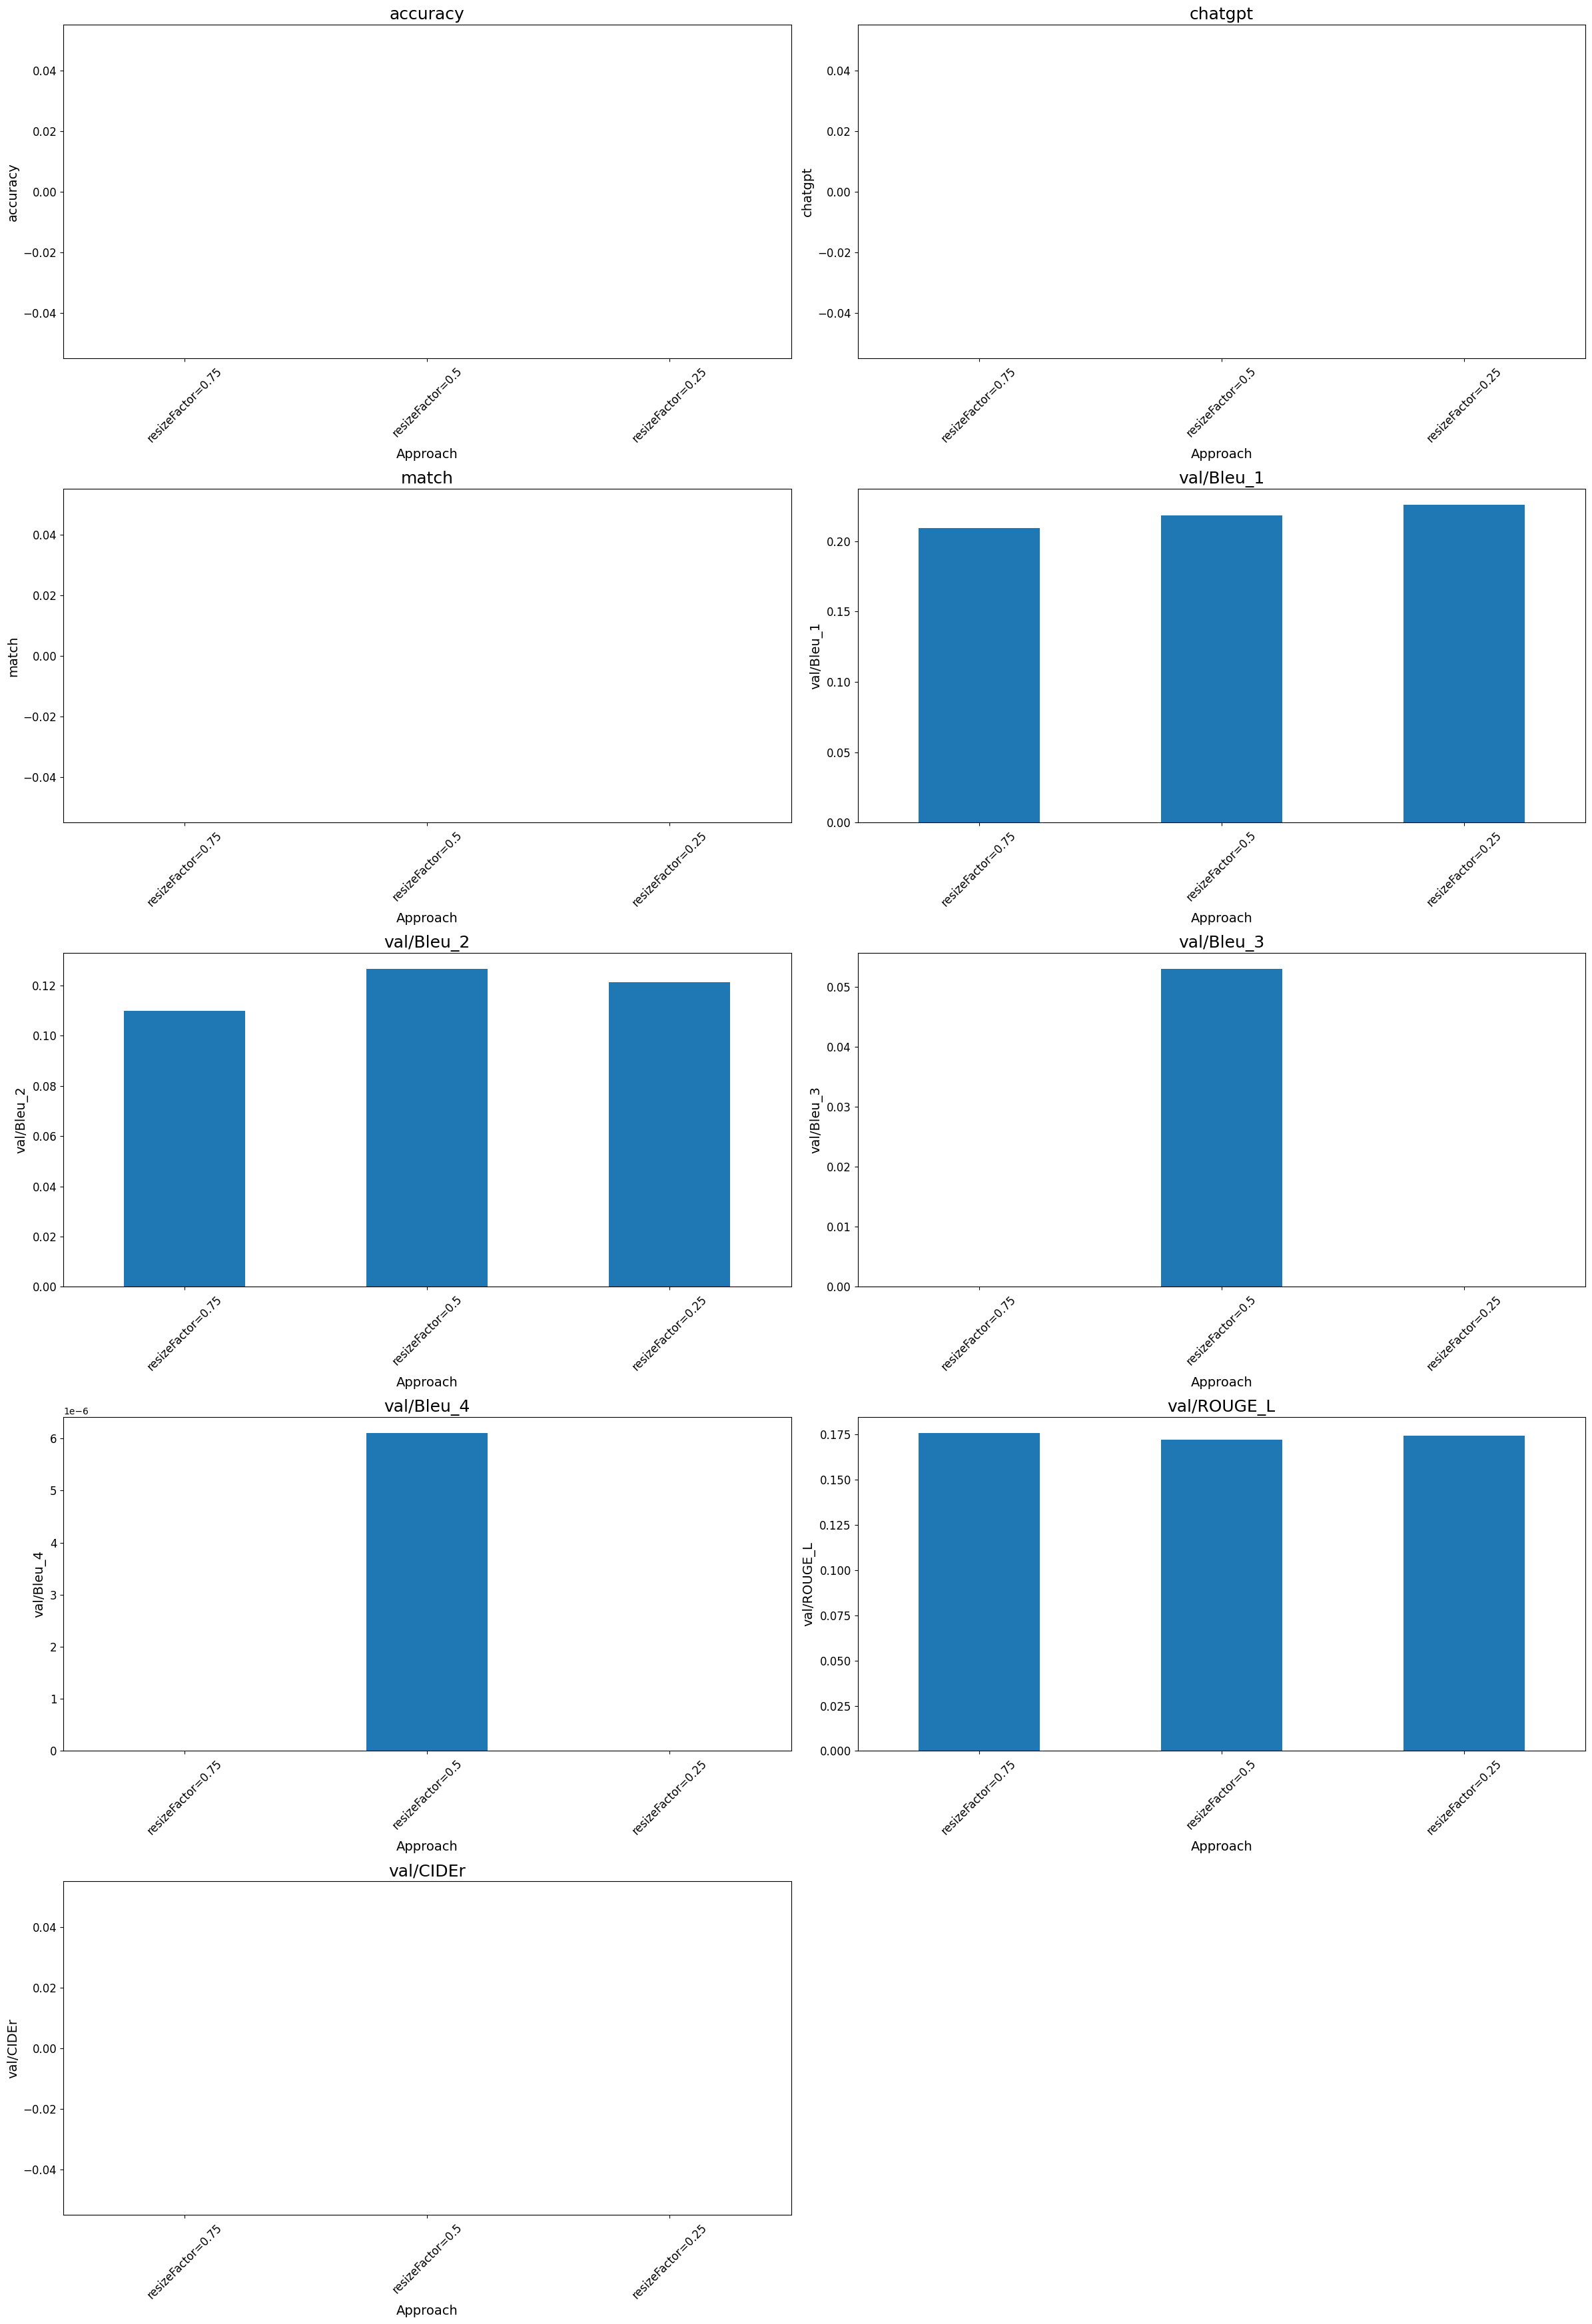

In [49]:
# Bar chats for score
n_cols = 2
n_rows = int(np.ceil(len(score_keys) / n_cols))
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(12 * n_cols, 7 * n_rows), sharey=False
)
axes = axes.flatten()  # Flatten in case of single row

for i, key in enumerate(score_keys):
    df.plot.bar(x="approach", y=key, ax=axes[i], legend=False)
    axes[i].set_title(key, fontsize=18)
    axes[i].set_xlabel("Approach", fontsize=14)
    axes[i].set_ylabel(key, fontsize=14)
    axes[i].tick_params(axis="x", rotation=45, labelsize=12)
    axes[i].tick_params(axis="y", labelsize=12)


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [46]:
#  Per-Question Analysis

# 10 Best & 10 Worst Questions for Each Score and Approach
per_question_score_keys = [
    "accuracy",
    "match",
    "Bleu_1",
    "Bleu_2",
    "Bleu_3",
    "Bleu_4",
    "ROUGE_L",
    "CIDEr",
]

for idx, row in df.iterrows():
    approach = row["approach"]
    model = row["model"]

    file = [f for f in result_files if os.path.basename(f).startswith(approach)][0]
    with open(file, "r") as f:
        data = json.load(f)
    per_q = data.get("per_question_scores", {})
    print(f"\n=== Model: {model} | Approach: {approach} ===")
    for score in per_question_score_keys:
        q_scores = [
            (qid, v.get(score)) for qid, v in per_q.items() if v.get(score) is not None
        ]
        if not q_scores:
            continue

        q_scores_sorted = sorted(q_scores, key=lambda x: x[1])

        print(f"\nScore: {score}")
        print("10 Worst:")
        display(pd.DataFrame(q_scores_sorted[:10], columns=["question_id", score]))
        print("10 Best:")
        display(pd.DataFrame(q_scores_sorted[-10:], columns=["question_id", score]))

# Mean, standard deviation, median of each score by approach
std_median_rows = []
for idx, row in df.iterrows():
    approach = row["approach"]
    model = row["model"]
    file = [f for f in result_files if os.path.basename(f).startswith(approach)][0]
    with open(file, "r") as f:
        data = json.load(f)
    per_q = data.get("per_question_scores", {})
    stats = {"model": model, "approach": approach}
    for score in per_question_score_keys:
        vals = [v.get(score) for v in per_q.values() if v.get(score) is not None]
        if vals:
            stats[f"{score}_mean"] = np.mean(vals)
            stats[f"{score}_std"] = np.std(vals)
            stats[f"{score}_median"] = np.median(vals)
        else:
            stats[f"{score}_mean"] = np.nan
            stats[f"{score}_std"] = np.nan
            stats[f"{score}_median"] = np.nan
    std_median_rows.append(stats)

std_median_df = pd.DataFrame(std_median_rows)
print("Standard deviation and median")
display(std_median_df)


=== Model: Qwen_Qwen2.5-VL-3B-Instruct | Approach: resizeFactor=0.75 ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,accuracy
0,75548269eb0a4614a6f84ab8d7713196_286308ef77444...,0.0
1,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
2,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
3,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.0
4,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.0
5,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.0
6,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
7,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0
8,6207269cb9474c14b01f9610b2ee30aa_505fe98faa284...,0.0
9,6207269cb9474c14b01f9610b2ee30aa_c42eec2e69014...,0.0



Score: match
10 Worst:


,question_id,match
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.0
5,ba76f4185aa34ed3bff467ac640da902_019813f350c74...,0.0
6,ba76f4185aa34ed3bff467ac640da902_d0c8108acf3a4...,0.0
7,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.0
8,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
9,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0


10 Best:


,question_id,match
0,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
1,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0
2,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.0
3,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.0
4,fe4fdd7a28754baeac7074ad78f55a52_115468e3e0964...,0.0
5,75548269eb0a4614a6f84ab8d7713196_f9c83042c0744...,0.0
6,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
7,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
8,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
9,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0



Score: Bleu_1
10 Worst:


,question_id,Bleu_1
0,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.108379
1,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.116505
2,1891b66d9f58463399aa242f3b521232_755b761322a04...,0.121495
3,ba76f4185aa34ed3bff467ac640da902_cfc098728fb64...,0.138889
4,df8dfada99a04a81bd1b102eeb84e9bc_af1b60ce78fd4...,0.141509
5,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.142857
6,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.142857
7,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.142857
8,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.144144
9,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.145455


10 Best:


,question_id,Bleu_1
0,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.239583
1,75548269eb0a4614a6f84ab8d7713196_648d919295694...,0.245614
2,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.250000
3,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.254545
4,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.265306
5,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.270270
6,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.272727
7,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.275229
8,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.275690
9,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.315068



Score: Bleu_2
10 Worst:


,question_id,Bleu_2
0,1891b66d9f58463399aa242f3b521232_755b761322a04...,0.033855
1,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.035875
2,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.036199
3,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,0.038001
4,1891b66d9f58463399aa242f3b521232_c1c99af601984...,0.038051
5,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.038051
6,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.041487
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.044525
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.047795
9,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.050735


10 Best:


,question_id,Bleu_2
0,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.123140
1,2422d2652f4f42298a389a6e0dfef307_d0c6d9ac1f564...,0.126184
2,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.127984
3,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.131061
4,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.138368
5,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.142784
6,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.147918
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.155794
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.160275
9,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.171709



Score: Bleu_3
10 Worst:


,question_id,Bleu_3
0,1891b66d9f58463399aa242f3b521232_755b761322a04...,2.218306e-07
1,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,2.270189e-07
2,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,2.290829e-07
3,1891b66d9f58463399aa242f3b521232_c1c99af601984...,2.361092e-07
4,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,2.361092e-07
5,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,2.380884e-07
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,2.638280e-07
7,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,2.758481e-07
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,2.828031e-07
9,ba76f4185aa34ed3bff467ac640da902_cfc098728fb64...,2.904040e-07


10 Best:


,question_id,Bleu_3
0,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.056887
1,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.058425
2,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.063766
3,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.065484
4,2422d2652f4f42298a389a6e0dfef307_d0c6d9ac1f564...,0.066975
5,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.067545
6,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.072500
7,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.081482
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.089360
9,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.089373



Score: Bleu_4
10 Worst:


,question_id,Bleu_4
0,1891b66d9f58463399aa242f3b521232_755b761322a04...,5.691907e-10
1,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,5.723872e-10
2,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,5.776151e-10
3,1891b66d9f58463399aa242f3b521232_c1c99af601984...,5.894922e-10
4,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,5.894922e-10
5,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,5.973478e-10
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,6.442902e-10
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,6.896252e-10
8,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,6.910822e-10
9,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,6.932355e-10


10 Best:


,question_id,Bleu_4
0,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.000007
1,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.000007
2,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.000008
3,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.000008
4,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.000008
5,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.000008
6,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.000009
7,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.037310
8,2422d2652f4f42298a389a6e0dfef307_d0c6d9ac1f564...,0.041128
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.050817



Score: ROUGE_L
10 Worst:


,question_id,ROUGE_L
0,ba76f4185aa34ed3bff467ac640da902_cfc098728fb64...,0.095194
1,df8dfada99a04a81bd1b102eeb84e9bc_af1b60ce78fd4...,0.097600
2,1977a1c98a6c4eb79fbc2a6dc0da9b0f_7903e67446c64...,0.104883
3,1891b66d9f58463399aa242f3b521232_755b761322a04...,0.106322
4,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,0.113788
5,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.113995
6,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.115457
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.119582
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_12ce09b519004...,0.122698
9,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,0.122881


10 Best:


,question_id,ROUGE_L
0,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.192374
1,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.192875
2,1977a1c98a6c4eb79fbc2a6dc0da9b0f_b6bf5a2bcb094...,0.193326
3,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.194113
4,fe4fdd7a28754baeac7074ad78f55a52_115468e3e0964...,0.205526
5,e0b14a8e11994763acba690bbcc3f56a_8a009c674c604...,0.208468
6,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.208587
7,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.222780
8,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.247842
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.247876



Score: CIDEr
10 Worst:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,CIDEr
0,75548269eb0a4614a6f84ab8d7713196_286308ef77444...,0.0
1,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
2,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
3,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.0
4,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.0
5,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.0
6,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
7,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0
8,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.0
9,17302a41218442ffbb0b094adb0669ab_e91815e429dc4...,0.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct | Approach: resizeFactor=0.5 ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,accuracy
0,75548269eb0a4614a6f84ab8d7713196_286308ef77444...,0.0
1,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
2,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
3,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.0
4,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.0
5,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.0
6,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
7,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0
8,6207269cb9474c14b01f9610b2ee30aa_505fe98faa284...,0.0
9,6207269cb9474c14b01f9610b2ee30aa_c42eec2e69014...,0.0



Score: match
10 Worst:


,question_id,match
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.0
5,ba76f4185aa34ed3bff467ac640da902_019813f350c74...,0.0
6,ba76f4185aa34ed3bff467ac640da902_d0c8108acf3a4...,0.0
7,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.0
8,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
9,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0


10 Best:


,question_id,match
0,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
1,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0
2,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.0
3,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.0
4,fe4fdd7a28754baeac7074ad78f55a52_115468e3e0964...,0.0
5,75548269eb0a4614a6f84ab8d7713196_f9c83042c0744...,0.0
6,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
7,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
8,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
9,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0



Score: Bleu_1
10 Worst:


,question_id,Bleu_1
0,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.102804
1,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,0.119266
2,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.123894
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.128440
4,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.144144
5,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,0.148148
6,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,0.154545
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.156643
8,df8dfada99a04a81bd1b102eeb84e9bc_3a171478d2d44...,0.157407
9,1891b66d9f58463399aa242f3b521232_90db859e92494...,0.157407


10 Best:


,question_id,Bleu_1
0,75548269eb0a4614a6f84ab8d7713196_648d919295694...,0.241071
1,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.245455
2,2422d2652f4f42298a389a6e0dfef307_3ea38d2fcb324...,0.252252
3,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.253165
4,df8dfada99a04a81bd1b102eeb84e9bc_1f1309a70c894...,0.254717
5,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.264151
6,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.266055
7,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.267857
8,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.282129
9,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.290797



Score: Bleu_2
10 Worst:


,question_id,Bleu_2
0,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.031142
1,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,0.033231
2,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.033260
3,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.036199
4,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,0.037210
5,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,0.037654
6,df8dfada99a04a81bd1b102eeb84e9bc_3a171478d2d44...,0.038355
7,1891b66d9f58463399aa242f3b521232_90db859e92494...,0.038355
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_12ce09b519004...,0.040175
9,1891b66d9f58463399aa242f3b521232_755b761322a04...,0.041693


10 Best:


,question_id,Bleu_2
0,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.119462
1,df8dfada99a04a81bd1b102eeb84e9bc_5d76d048762e4...,0.123879
2,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.124309
3,17302a41218442ffbb0b094adb0669ab_e91815e429dc4...,0.126544
4,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.136648
5,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.137876
6,df8dfada99a04a81bd1b102eeb84e9bc_1f1309a70c894...,0.139309
7,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.139550
8,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.148900
9,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.162925



Score: Bleu_3
10 Worst:


,question_id,Bleu_3
0,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,2.098157e-07
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,2.151970e-07
2,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,2.177224e-07
3,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,2.290829e-07
4,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,2.355061e-07
5,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,2.359040e-07
6,df8dfada99a04a81bd1b102eeb84e9bc_3a171478d2d44...,2.403137e-07
7,1891b66d9f58463399aa242f3b521232_90db859e92494...,2.403137e-07
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_12ce09b519004...,2.470813e-07
9,1891b66d9f58463399aa242f3b521232_755b761322a04...,2.501887e-07


10 Best:


,question_id,Bleu_3
0,17302a41218442ffbb0b094adb0669ab_e91815e429dc4...,0.052928
1,df8dfada99a04a81bd1b102eeb84e9bc_1f1309a70c894...,0.057145
2,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.059175
3,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.059976
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.061720
5,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.064059
6,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.070192
7,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.072687
8,df8dfada99a04a81bd1b102eeb84e9bc_5d76d048762e4...,0.075260
9,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.078440



Score: Bleu_4
10 Worst:


,question_id,Bleu_4
0,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,5.459088e-10
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,5.486293e-10
2,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,5.585999e-10
3,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,5.776151e-10
4,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,5.918417e-10
5,76c632788f8c4516bef1c4297f2002f6_60e3bedfbb7a4...,5.938877e-10
6,df8dfada99a04a81bd1b102eeb84e9bc_3a171478d2d44...,6.029573e-10
7,1891b66d9f58463399aa242f3b521232_90db859e92494...,6.029573e-10
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_12ce09b519004...,6.141910e-10
9,1891b66d9f58463399aa242f3b521232_755b761322a04...,6.142606e-10


10 Best:


,question_id,Bleu_4
0,df8dfada99a04a81bd1b102eeb84e9bc_1f1309a70c894...,0.000007
1,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.000007
2,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.000007
3,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.000007
4,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.000007
5,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.000007
6,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.000008
7,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.042405
8,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.044493
9,df8dfada99a04a81bd1b102eeb84e9bc_5d76d048762e4...,0.044676



Score: ROUGE_L
10 Worst:


,question_id,ROUGE_L
0,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,0.083319
1,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.101561
2,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.102456
3,1891b66d9f58463399aa242f3b521232_c1c99af601984...,0.104942
4,1891b66d9f58463399aa242f3b521232_828b240f29074...,0.112047
5,df8dfada99a04a81bd1b102eeb84e9bc_3a171478d2d44...,0.114349
6,1891b66d9f58463399aa242f3b521232_90db859e92494...,0.116493
7,2422d2652f4f42298a389a6e0dfef307_d0c6d9ac1f564...,0.116777
8,2422d2652f4f42298a389a6e0dfef307_5124bf7488f14...,0.117575
9,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.120972


10 Best:


,question_id,ROUGE_L
0,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.199222
1,1977a1c98a6c4eb79fbc2a6dc0da9b0f_0a208b6bd70a4...,0.201062
2,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.201062
3,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.202261
4,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.206656
5,1977a1c98a6c4eb79fbc2a6dc0da9b0f_947c1b70cff64...,0.211601
6,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.217913
7,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.226231
8,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.237706
9,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.267199



Score: CIDEr
10 Worst:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,CIDEr
0,75548269eb0a4614a6f84ab8d7713196_286308ef77444...,0.0
1,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
2,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
3,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.0
4,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.0
5,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.0
6,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
7,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0
8,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.0
9,17302a41218442ffbb0b094adb0669ab_e91815e429dc4...,0.0



=== Model: Qwen_Qwen2.5-VL-3B-Instruct | Approach: resizeFactor=0.25 ===

Score: accuracy
10 Worst:


,question_id,accuracy
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,accuracy
0,75548269eb0a4614a6f84ab8d7713196_286308ef77444...,0.0
1,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
2,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
3,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.0
4,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.0
5,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.0
6,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
7,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0
8,6207269cb9474c14b01f9610b2ee30aa_505fe98faa284...,0.0
9,6207269cb9474c14b01f9610b2ee30aa_c42eec2e69014...,0.0



Score: match
10 Worst:


,question_id,match
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.0
5,ba76f4185aa34ed3bff467ac640da902_019813f350c74...,0.0
6,ba76f4185aa34ed3bff467ac640da902_d0c8108acf3a4...,0.0
7,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.0
8,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
9,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0


10 Best:


,question_id,match
0,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.0
1,76c632788f8c4516bef1c4297f2002f6_3dab7043733e4...,0.0
2,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.0
3,fe4fdd7a28754baeac7074ad78f55a52_a7924f68e0704...,0.0
4,fe4fdd7a28754baeac7074ad78f55a52_115468e3e0964...,0.0
5,75548269eb0a4614a6f84ab8d7713196_f9c83042c0744...,0.0
6,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
7,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
8,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
9,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0



Score: Bleu_1
10 Worst:


,question_id,Bleu_1
0,1891b66d9f58463399aa242f3b521232_c1c99af601984...,0.122642
1,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,0.125000
2,1891b66d9f58463399aa242f3b521232_eff4ca737a734...,0.127445
3,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.128205
4,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.128440
5,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.128440
6,1891b66d9f58463399aa242f3b521232_90db859e92494...,0.133333
7,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.136364
8,ba76f4185aa34ed3bff467ac640da902_b48b532c3e194...,0.138889
9,76c632788f8c4516bef1c4297f2002f6_e50b488783c64...,0.146789


10 Best:


,question_id,Bleu_1
0,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.238446
1,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.238532
2,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.243243
3,76c632788f8c4516bef1c4297f2002f6_16fc3cc5a0b74...,0.247706
4,2422d2652f4f42298a389a6e0dfef307_e2c5111b0a234...,0.250000
5,df8dfada99a04a81bd1b102eeb84e9bc_0545b9cffcb44...,0.256689
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_0a208b6bd70a4...,0.264706
7,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.286277
8,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.290797
9,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.337673



Score: Bleu_2
10 Worst:


,question_id,Bleu_2
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.033245
1,1891b66d9f58463399aa242f3b521232_c1c99af601984...,0.034176
2,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,0.034837
3,1891b66d9f58463399aa242f3b521232_eff4ca737a734...,0.035523
4,ba76f4185aa34ed3bff467ac640da902_b48b532c3e194...,0.036028
5,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,0.037314
6,76c632788f8c4516bef1c4297f2002f6_182b5e160c6f4...,0.037559
7,1891b66d9f58463399aa242f3b521232_828b240f29074...,0.037559
8,1891b66d9f58463399aa242f3b521232_755b761322a04...,0.039103
9,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.040472


10 Best:


,question_id,Bleu_2
0,1977a1c98a6c4eb79fbc2a6dc0da9b0f_fc4a9c4a63534...,0.116642
1,2422d2652f4f42298a389a6e0dfef307_bac9648d9bfb4...,0.119462
2,17302a41218442ffbb0b094adb0669ab_e91815e429dc4...,0.121353
3,76c632788f8c4516bef1c4297f2002f6_16fc3cc5a0b74...,0.135457
4,2422d2652f4f42298a389a6e0dfef307_e2c5111b0a234...,0.136717
5,1977a1c98a6c4eb79fbc2a6dc0da9b0f_0a208b6bd70a4...,0.144799
6,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.154944
7,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.155963
8,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.161974
9,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.192576



Score: Bleu_3
10 Worst:


,question_id,Bleu_3
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,2.126098e-07
1,1891b66d9f58463399aa242f3b521232_c1c99af601984...,2.239434e-07
2,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,2.282921e-07
3,ba76f4185aa34ed3bff467ac640da902_b48b532c3e194...,2.304938e-07
4,1891b66d9f58463399aa242f3b521232_eff4ca737a734...,2.328247e-07
5,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,2.337593e-07
6,76c632788f8c4516bef1c4297f2002f6_182b5e160c6f4...,2.377280e-07
7,1891b66d9f58463399aa242f3b521232_828b240f29074...,2.377280e-07
8,1891b66d9f58463399aa242f3b521232_755b761322a04...,2.426682e-07
9,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,2.467720e-07


10 Best:


,question_id,Bleu_3
0,76c632788f8c4516bef1c4297f2002f6_16fc3cc5a0b74...,0.055557
1,2422d2652f4f42298a389a6e0dfef307_e2c5111b0a234...,0.056076
2,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.056220
3,ba76f4185aa34ed3bff467ac640da902_019813f350c74...,0.057543
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_fc4a9c4a63534...,0.065462
5,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.078992
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_0a208b6bd70a4...,0.085681
7,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.087371
8,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.087481
9,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.101160



Score: Bleu_4
10 Worst:


,question_id,Bleu_4
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,5.388417e-10
1,1891b66d9f58463399aa242f3b521232_c1c99af601984...,5.746381e-10
2,ba76f4185aa34ed3bff467ac640da902_b48b532c3e194...,5.843824e-10
3,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,5.858519e-10
4,1891b66d9f58463399aa242f3b521232_ce63dd8c7f6a4...,5.864362e-10
5,1891b66d9f58463399aa242f3b521232_eff4ca737a734...,5.975720e-10
6,76c632788f8c4516bef1c4297f2002f6_182b5e160c6f4...,5.995176e-10
7,1891b66d9f58463399aa242f3b521232_828b240f29074...,5.995176e-10
8,1891b66d9f58463399aa242f3b521232_755b761322a04...,6.059449e-10
9,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,6.107536e-10


10 Best:


,question_id,Bleu_4
0,2422d2652f4f42298a389a6e0dfef307_e2c5111b0a234...,0.000006
1,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.000007
2,1977a1c98a6c4eb79fbc2a6dc0da9b0f_fc4a9c4a63534...,0.000007
3,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.000010
4,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.000011
5,e0b14a8e11994763acba690bbcc3f56a_7138a5bb57984...,0.034662
6,ba76f4185aa34ed3bff467ac640da902_019813f350c74...,0.036616
7,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.049897
8,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.049972
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_0a208b6bd70a4...,0.050206



Score: ROUGE_L
10 Worst:


,question_id,ROUGE_L
0,1891b66d9f58463399aa242f3b521232_90db859e92494...,0.096570
1,76c632788f8c4516bef1c4297f2002f6_182b5e160c6f4...,0.103374
2,1891b66d9f58463399aa242f3b521232_c1c99af601984...,0.104942
3,ba76f4185aa34ed3bff467ac640da902_b48b532c3e194...,0.114232
4,e0b14a8e11994763acba690bbcc3f56a_8a76c43c5a034...,0.115191
5,1891b66d9f58463399aa242f3b521232_1662ec71669e4...,0.117062
6,1891b66d9f58463399aa242f3b521232_eff4ca737a734...,0.118122
7,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.120972
8,df8dfada99a04a81bd1b102eeb84e9bc_5d76d048762e4...,0.121235
9,75548269eb0a4614a6f84ab8d7713196_286308ef77444...,0.122113


10 Best:


,question_id,ROUGE_L
0,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.195019
1,76c632788f8c4516bef1c4297f2002f6_30e9bf9ff66b4...,0.203748
2,76c632788f8c4516bef1c4297f2002f6_16fc3cc5a0b74...,0.205119
3,fe4fdd7a28754baeac7074ad78f55a52_8f4d3fb0381d4...,0.206996
4,1977a1c98a6c4eb79fbc2a6dc0da9b0f_a59f97b9ba4b4...,0.208058
5,df8dfada99a04a81bd1b102eeb84e9bc_e3f986e5d53f4...,0.211454
6,1977a1c98a6c4eb79fbc2a6dc0da9b0f_0a208b6bd70a4...,0.219258
7,2422d2652f4f42298a389a6e0dfef307_bac9648d9bfb4...,0.219466
8,fe4fdd7a28754baeac7074ad78f55a52_b4a6de0585664...,0.244489
9,e0b14a8e11994763acba690bbcc3f56a_0e364b7146c84...,0.262805



Score: CIDEr
10 Worst:


,question_id,CIDEr
0,f0f120e4d4b0441da90ec53b16ee169d_4a0798f849ca4...,0.0
1,f0f120e4d4b0441da90ec53b16ee169d_ffd1bdf020d14...,0.0
2,f0f120e4d4b0441da90ec53b16ee169d_d9075c2a5f864...,0.0
3,f0f120e4d4b0441da90ec53b16ee169d_dfb8d8959b994...,0.0
4,54cdaaae372d421fa4734d66f51a8c48_542eaf1fc9b34...,0.0
5,54cdaaae372d421fa4734d66f51a8c48_1b45a97a0e5e4...,0.0
6,54cdaaae372d421fa4734d66f51a8c48_d5e16062410f4...,0.0
7,54cdaaae372d421fa4734d66f51a8c48_7abe79e5d3d74...,0.0
8,54cdaaae372d421fa4734d66f51a8c48_0dd14c14cea14...,0.0
9,1977a1c98a6c4eb79fbc2a6dc0da9b0f_bd8a5e326b804...,0.0


10 Best:


,question_id,CIDEr
0,75548269eb0a4614a6f84ab8d7713196_286308ef77444...,0.0
1,75548269eb0a4614a6f84ab8d7713196_1ca510ff9d664...,0.0
2,75548269eb0a4614a6f84ab8d7713196_529bd74bd2884...,0.0
3,75548269eb0a4614a6f84ab8d7713196_d5817b9ad0b64...,0.0
4,75548269eb0a4614a6f84ab8d7713196_4aefbf8c202f4...,0.0
5,17302a41218442ffbb0b094adb0669ab_dd86d69f10614...,0.0
6,17302a41218442ffbb0b094adb0669ab_072f15feb4924...,0.0
7,17302a41218442ffbb0b094adb0669ab_8d52c5a0c78a4...,0.0
8,17302a41218442ffbb0b094adb0669ab_9fe998b6018f4...,0.0
9,17302a41218442ffbb0b094adb0669ab_e91815e429dc4...,0.0


Standard deviation and median


,model,approach,accuracy_mean,accuracy_std,accuracy_median,match_mean,match_std,match_median,Bleu_1_mean,Bleu_1_std,...,Bleu_3_median,Bleu_4_mean,Bleu_4_std,Bleu_4_median,ROUGE_L_mean,ROUGE_L_std,ROUGE_L_median,CIDEr_mean,CIDEr_std,CIDEr_median
0,Qwen_Qwen2.5-VL-3B-Instruct,resizeFactor=0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.194632,0.041889,...,4.425982e-07,0.001823,0.008745,9.595536e-10,0.158808,0.032479,0.161552,0.0,0.0,0.0
1,Qwen_Qwen2.5-VL-3B-Instruct,resizeFactor=0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.194833,0.038679,...,4.200904e-07,0.001855,0.008825,9.172951e-10,0.157423,0.034325,0.153943,0.0,0.0,0.0
2,Qwen_Qwen2.5-VL-3B-Instruct,resizeFactor=0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.192014,0.042188,...,4.461542e-07,0.003120,0.011481,9.544821e-10,0.159528,0.033777,0.158538,0.0,0.0,0.0
